# BERT Fine-tuning Pipeline with Model Saving and Modification Testing

This notebook implements a complete pipeline for:
1. Loading data from CSV files
2. Fine-tuning BERT model
3. Saving the trained model
4. Testing modifications on the same test data
5. Comparing accuracies

## 1. Setup and Imports

In [1]:
# Cell 1 - Imports and setup
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import time
import datetime
import random
import os
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from transformers import (
    AutoTokenizer,
    AutoModel,
    AutoConfig,
    get_constant_schedule_with_warmup
)
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Set random seeds for reproducibility
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed_val)

print(f"Using PyTorch {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

/home/jivnesh/anaconda3/envs/harshitml/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using PyTorch 2.7.1+cu126
CUDA available: True
GPU: NVIDIA A100 80GB PCIe
GPU: NVIDIA A100 80GB PCIe


## 2. Configuration Parameters

In [15]:
# Cell 2 - Configuration
#--------------------------------
#  Model and Training Parameters
#--------------------------------
model_name = "bert-base-cased"  # Can be changed to other BERT variants
max_seq_length = 128
batch_size = 32
num_train_epochs = 3
learning_rate = 2e-5
dropout_rate = 0.1

#--------------------------------
#  Data Parameters
#--------------------------------
# Update these paths to your CSV files
train_csv_path = "/home/jivnesh/Harshit_Surge/dataset/raid/train.csv"
test_data_save_path = "/home/jivnesh/Harshit_Surge/dataset/test_data_jailbreak.csv"  # Save test data here
train_data_save_path = "/home/jivnesh/Harshit_Surge/dataset/train_data_jailbreak.csv"  # Save train data here

# Data sampling parameters
train_sample_size = 80000  # 80k for training
test_sample_size = 20000   # 20k for testing
min_adversarial_attacks = 20000  # At least 20k samples where attack is not None
test_size = test_sample_size / (train_sample_size + test_sample_size)  # Calculate proportion

#--------------------------------
#  Device Configuration
#--------------------------------
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

#--------------------------------
#  Model Save Path
#--------------------------------
model_save_dir = "./saved_models"
os.makedirs(model_save_dir, exist_ok=True)
model_save_path = os.path.join(model_save_dir, "bert_finetuned_model.pth")

print(f"Model will be saved to: {model_save_path}")
print(f"Test data will be saved to: {test_data_save_path}")
print(f"Training samples: {train_sample_size}, Test samples: {test_sample_size}")
print(f"Required adversarial attacks: {min_adversarial_attacks}")

Using device: cuda:0
Model will be saved to: ./saved_models/bert_finetuned_model.pth
Test data will be saved to: /home/jivnesh/Harshit_Surge/dataset/test_data_jailbreak.csv
Training samples: 80000, Test samples: 20000
Required adversarial attacks: 20000


## 3. Data Loading and Preprocessing

In [5]:
data = pd.read_csv(train_csv_path)

In [10]:
def load_and_prepare_data(data,
                          selected_models=None,
                          per_attack_per_model=1000,
                          none_attack_per_model=3000,  # New parameter for 'none' attack samples
                          human_samples=40000,
                          test_size=20000):
    """
    Load data and sample per-model per-attack types, plus human and test split.
    """
    # Ensure text column
    if 'text' not in data.columns:
        if 'title' in data.columns and 'generation' in data.columns:
            data['text'] = data['title'] + ' ' + data['generation']
        else:
            raise ValueError("No 'text' column found and cannot create from 'title'+'generation'")

    # Filter models
    if selected_models:
        data = data[data['model'].isin(selected_models + ['human'])]

    # Label
    data['label'] = (data['model'] != 'human').astype(int)
    data['attack'] = data.get('attack', pd.NA)

    # Collect sampled rows
    sampled_rows = []

    # Process each model separately
    models = data['model'].unique().tolist()
    attacks = [a for a in data['attack'].dropna().unique().tolist() if a != 'none']

    for m in models:
        model_df = data[data['model'] == m]
        if m == 'human':
            # Sample fixed human texts
            sampled = model_df.sample(min(len(model_df), human_samples), random_state=42)
            sampled_rows.append(sampled)
            continue

        # Sample 'none' attack examples specifically
        none_attack_df = model_df[model_df['attack'] == 'none']
        if len(none_attack_df) >= none_attack_per_model:
            none_sampled = none_attack_df.sample(none_attack_per_model, random_state=42)
            sampled_rows.append(none_sampled)
        else:
            # If not enough 'none' attack samples, take all available
            sampled_rows.append(none_attack_df)
            print(f"Warning: Only {len(none_attack_df)} 'none' attack samples available for {m} (wanted {none_attack_per_model})")

        # For each attack type
        for atk in attacks:
            atk_df = model_df[model_df['attack'] == atk]
            if len(atk_df) >= per_attack_per_model:
                sampled = atk_df.sample(per_attack_per_model, random_state=42)
            else:
                # Take all and pad with non-attack examples (excluding those already sampled for 'none')
                sampled = atk_df.copy()
                needed = per_attack_per_model - len(atk_df)
                remaining_df = model_df[(model_df['attack'].isna())]
                pad = remaining_df.sample(min(len(remaining_df), needed), random_state=42)
                sampled = pd.concat([sampled, pad])
            sampled_rows.append(sampled)

    # Combine
    full_data = pd.concat(sampled_rows).reset_index(drop=True)

    # Use pre-defined test size ratio to create train/test split
    train_data, test_data = train_test_split(
        full_data, test_size=test_size, random_state=42, stratify=full_data['label']
    )
    
    print(f"Final dataset: {len(full_data)} total samples")
    print(f"Train dataset: {len(train_data)} samples")
    print(f"Test dataset: {len(test_data)} samples")

    return train_data, test_data

# Example usage:
full_data = data.copy()
selected_models = ['chatgpt', 'mistral', 'cohere', 'llama-chat', 'gpt4', 'mpt-chat']
train_data, test_data = load_and_prepare_data(full_data, selected_models)


/tmp/ipykernel_2102743/3653482389.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['label'] = (data['model'] != 'human').astype(int)
/tmp/ipykernel_2102743/3653482389.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['attack'] = data.get('attack', pd.NA)


Final dataset: 124000 total samples
Train dataset: 104000 samples
Test dataset: 20000 samples


In [11]:
train_data.head()

,id,adv_source_id,source_id,model,decoding,repetition_penalty,attack,domain,title,prompt,generation,text,label
76673,191366ea-0848-4b0e-8cf5-078e19f9ec41,e0818c4e-914e-4595-a88f-7f2fe2788d2c,bc1c0435-0e5d-43fc-aade-3ce40e37ae03,mistral,sampling,yes,number,news,Triple triumph for Little Britain,The following is the full text of a news artic...,English comedian and actor Matt Lucas has been...,Triple triumph for Little Britain English come...,1
85257,f93ba591-b4e8-431c-a1ff-d789c97da165,db9d9cbd-0e24-4674-854f-59dc94f18797,7395a389-8b73-4b65-bf32-5c31947d49a5,cohere,sampling,no,whitespace,news,New media battle for Bafta awards,The following is the full text of a news artic...,bbc.com/news/business-36347043\n\nFilm critics...,New media battle for Bafta awards bbc.com/news...,1
116739,d403c713-acea-4d6e-8ab2-bbacc8ee0cef,de1586a3-eb83-483a-a80a-94dbb924d9b4,8598c9e2-8e28-46b2-a6da-a22b767aae49,gpt4,greedy,no,perplexity_misspelling,news,Da Vinci film to star Tom Hanks,"Write the body of a BBC news article titled ""D...",Hollywood actor Tom Hanks is set to star in a ...,Da Vinci film to star Tom Hanks Hollywood acto...,1
104059,1a93a0d4-33ab-43b4-abf1-38b64cd2449c,038809be-7ed0-4990-b75d-ec4fc8fd805c,56e07378-f387-42d8-aafc-68dcac72e01f,chatgpt,sampling,no,number,books,Ancestors of Avalon,Write the body of a plot summary for a novel t...,Ancestors of Avalon is a gripping historical f...,Ancestors of Avalon Ancestors of Avalon is a g...,1
37642,aa93c3dc-46ff-4768-972c-360c88c05abe,5b2a1e8d-19d9-4a6e-b903-8487e85d4698,5b2a1e8d-19d9-4a6e-b903-8487e85d4698,human,NaN,NaN,article_deletion,reviews,Edward Scissorhands,NaN,Many people say the cried at the end of this m...,Edward Scissorhands Many people say the cried ...,0


## visualize training data


<Figure size 1200x600 with 0 Axes>

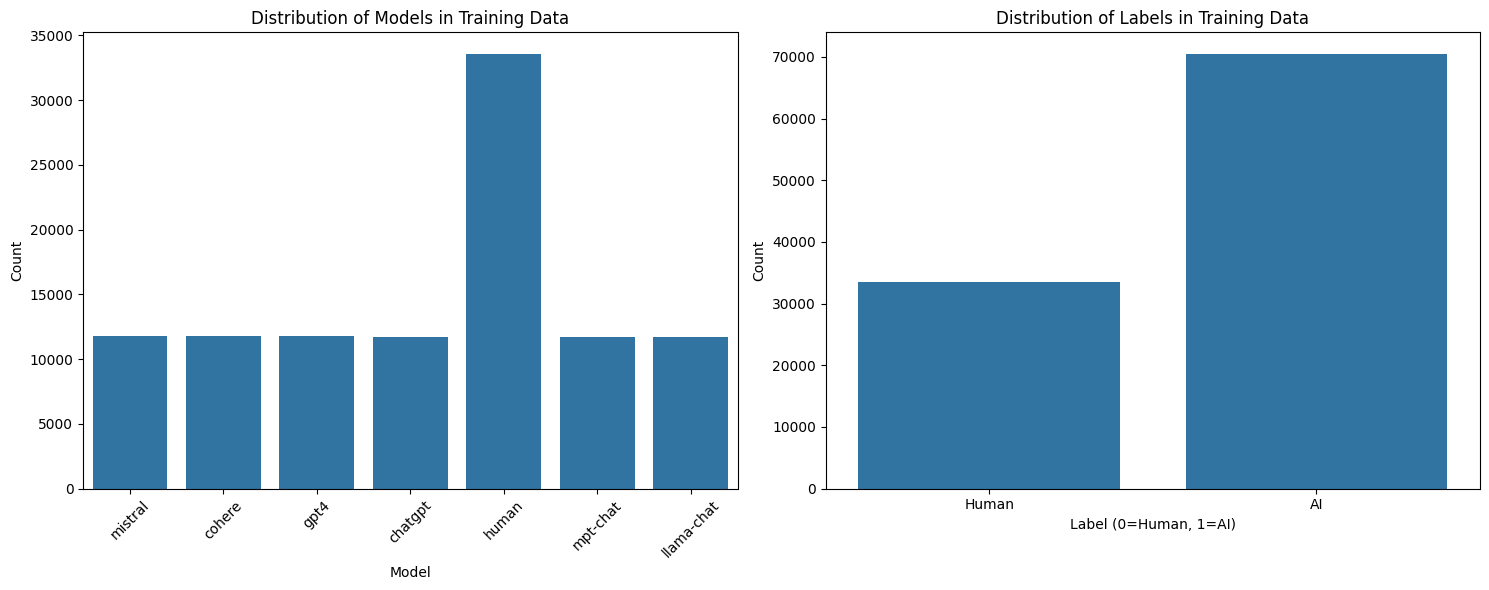

Training Data Distribution Summary:
Total samples: 104000

Model distribution:
model
human         33548
mistral       11796
cohere        11766
gpt4          11757
mpt-chat      11737
chatgpt       11722
llama-chat    11674
Name: count, dtype: int64

Label distribution:
label
1    70452
0    33548
Name: count, dtype: int64

Label percentages:


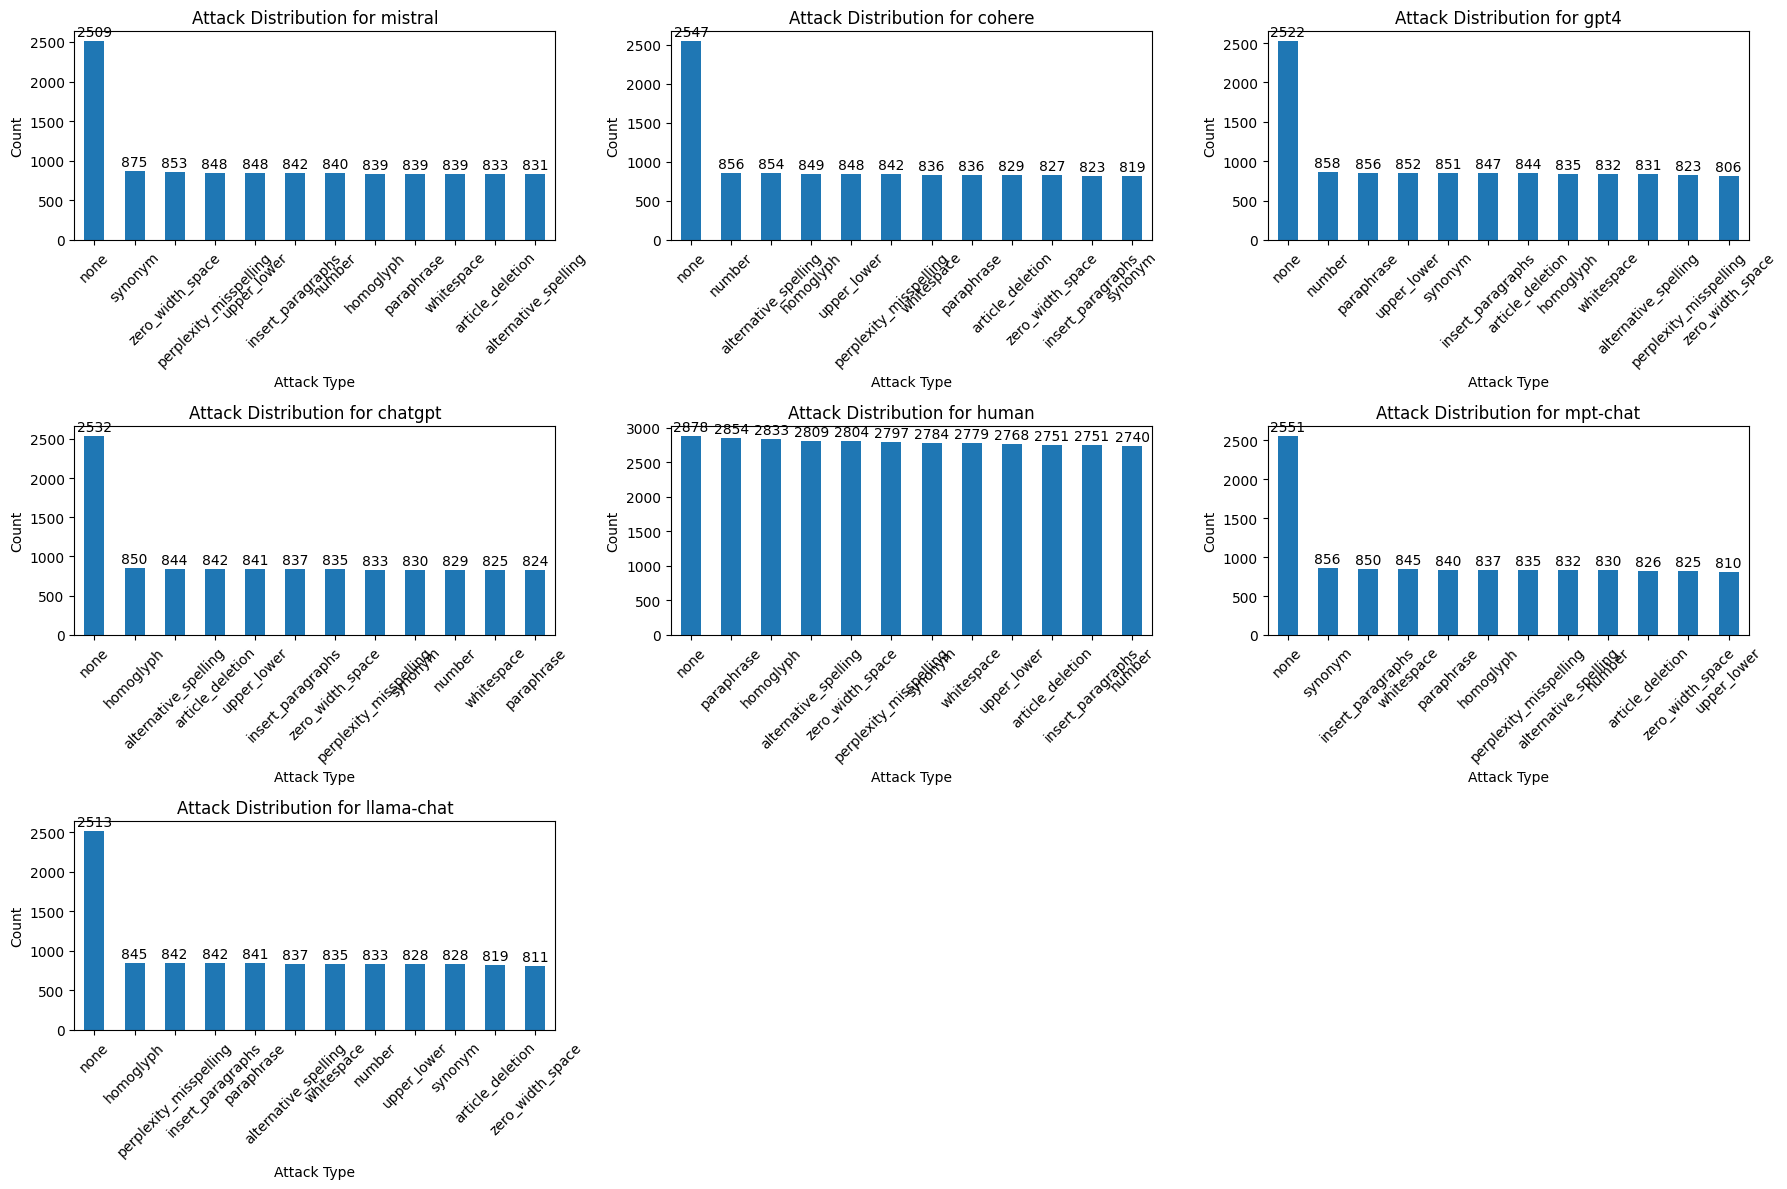


Detailed Attack Distribution by Model:

MISTRAL:
attack
none                      2509
synonym                    875
zero_width_space           853
perplexity_misspelling     848
upper_lower                848
insert_paragraphs          842
number                     840
homoglyph                  839
paraphrase                 839
whitespace                 839
article_deletion           833
alternative_spelling       831
Name: count, dtype: int64
Total samples: 11796

COHERE:
attack
none                      2547
number                     856
alternative_spelling       854
homoglyph                  849
upper_lower                848
perplexity_misspelling     842
whitespace                 836
paraphrase                 836
article_deletion           829
zero_width_space           827
insert_paragraphs          823
synonym                    819
Name: count, dtype: int64
Total samples: 11766

GPT4:
attack
none                      2522
number                     858
paraphrase   

In [12]:
import seaborn as sns

import matplotlib.pyplot as plt

# Plot distribution of model categories in training data
plt.figure(figsize=(12, 6))

# Create subplots for better visualization
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Model distribution
sns.countplot(data=train_data, x='model', ax=axes[0])
axes[0].set_title('Distribution of Models in Training Data')
axes[0].set_xlabel('Model')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=45)

# Plot 2: Label distribution (Human vs AI)
sns.countplot(data=train_data, x='label', ax=axes[1])
axes[1].set_title('Distribution of Labels in Training Data')
axes[1].set_xlabel('Label (0=Human, 1=AI)')
axes[1].set_ylabel('Count')
axes[1].set_xticks([0, 1])
axes[1].set_xticklabels(['Human', 'AI'])

plt.tight_layout()
plt.show()

# Print summary statistics
print("Training Data Distribution Summary:")
print("="*40)
print(f"Total samples: {len(train_data)}")
print(f"\nModel distribution:")
print(train_data['model'].value_counts())
print(f"\nLabel distribution:")
print(train_data['label'].value_counts())
print(f"\nLabel percentages:")

# Plot attack distribution for each model
models = train_data['model'].unique()
n_models = len(models)

# Create subplots - arrange in 2 rows for better visualization
n_cols = 3
n_rows = (n_models + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 12))
axes = axes.flatten()  # Flatten for easier indexing

for i, model in enumerate(models):
    model_data = train_data[train_data['model'] == model]
    
    # Count attack distribution for this model
    attack_counts = model_data['attack'].value_counts()
    
    # Create bar plot
    ax = axes[i]
    attack_counts.plot(kind='bar', ax=ax)
    ax.set_title(f'Attack Distribution for {model}')
    ax.set_xlabel('Attack Type')
    ax.set_ylabel('Count')
    ax.tick_params(axis='x', rotation=45)
    
    # Add value labels on bars
    for j, v in enumerate(attack_counts.values):
        ax.text(j, v + max(attack_counts.values) * 0.01, str(v), ha='center', va='bottom')

# Hide unused subplots
for i in range(n_models, len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

# Print detailed attack distribution per model
print("\nDetailed Attack Distribution by Model:")
print("="*60)
for model in models:
    model_data = train_data[train_data['model'] == model]
    print(f"\n{model.upper()}:")
    print(model_data['attack'].value_counts())
    print(f"Total samples: {len(model_data)}")


<Figure size 1200x600 with 0 Axes>

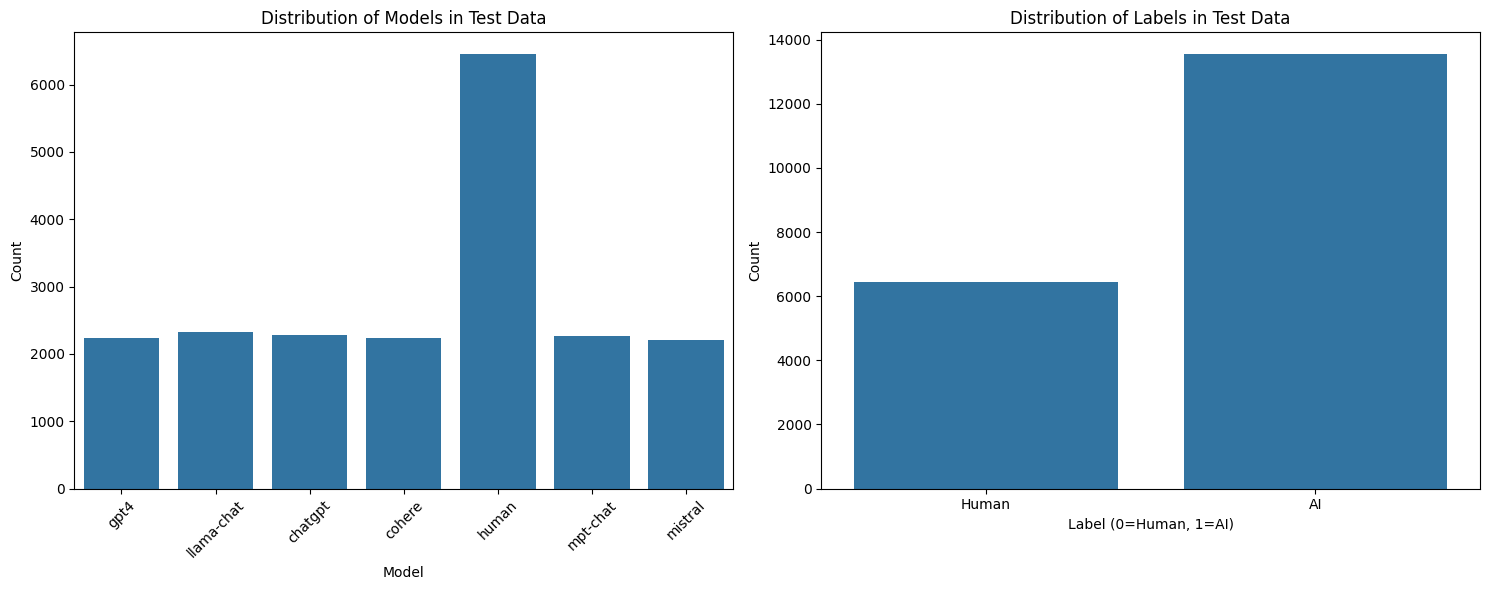

Test Data Distribution Summary:
Total samples: 20000

Model distribution:
model
human         6452
llama-chat    2326
chatgpt       2278
mpt-chat      2263
gpt4          2243
cohere        2234
mistral       2204
Name: count, dtype: int64

Label distribution:
label
1    13548
0     6452
Name: count, dtype: int64


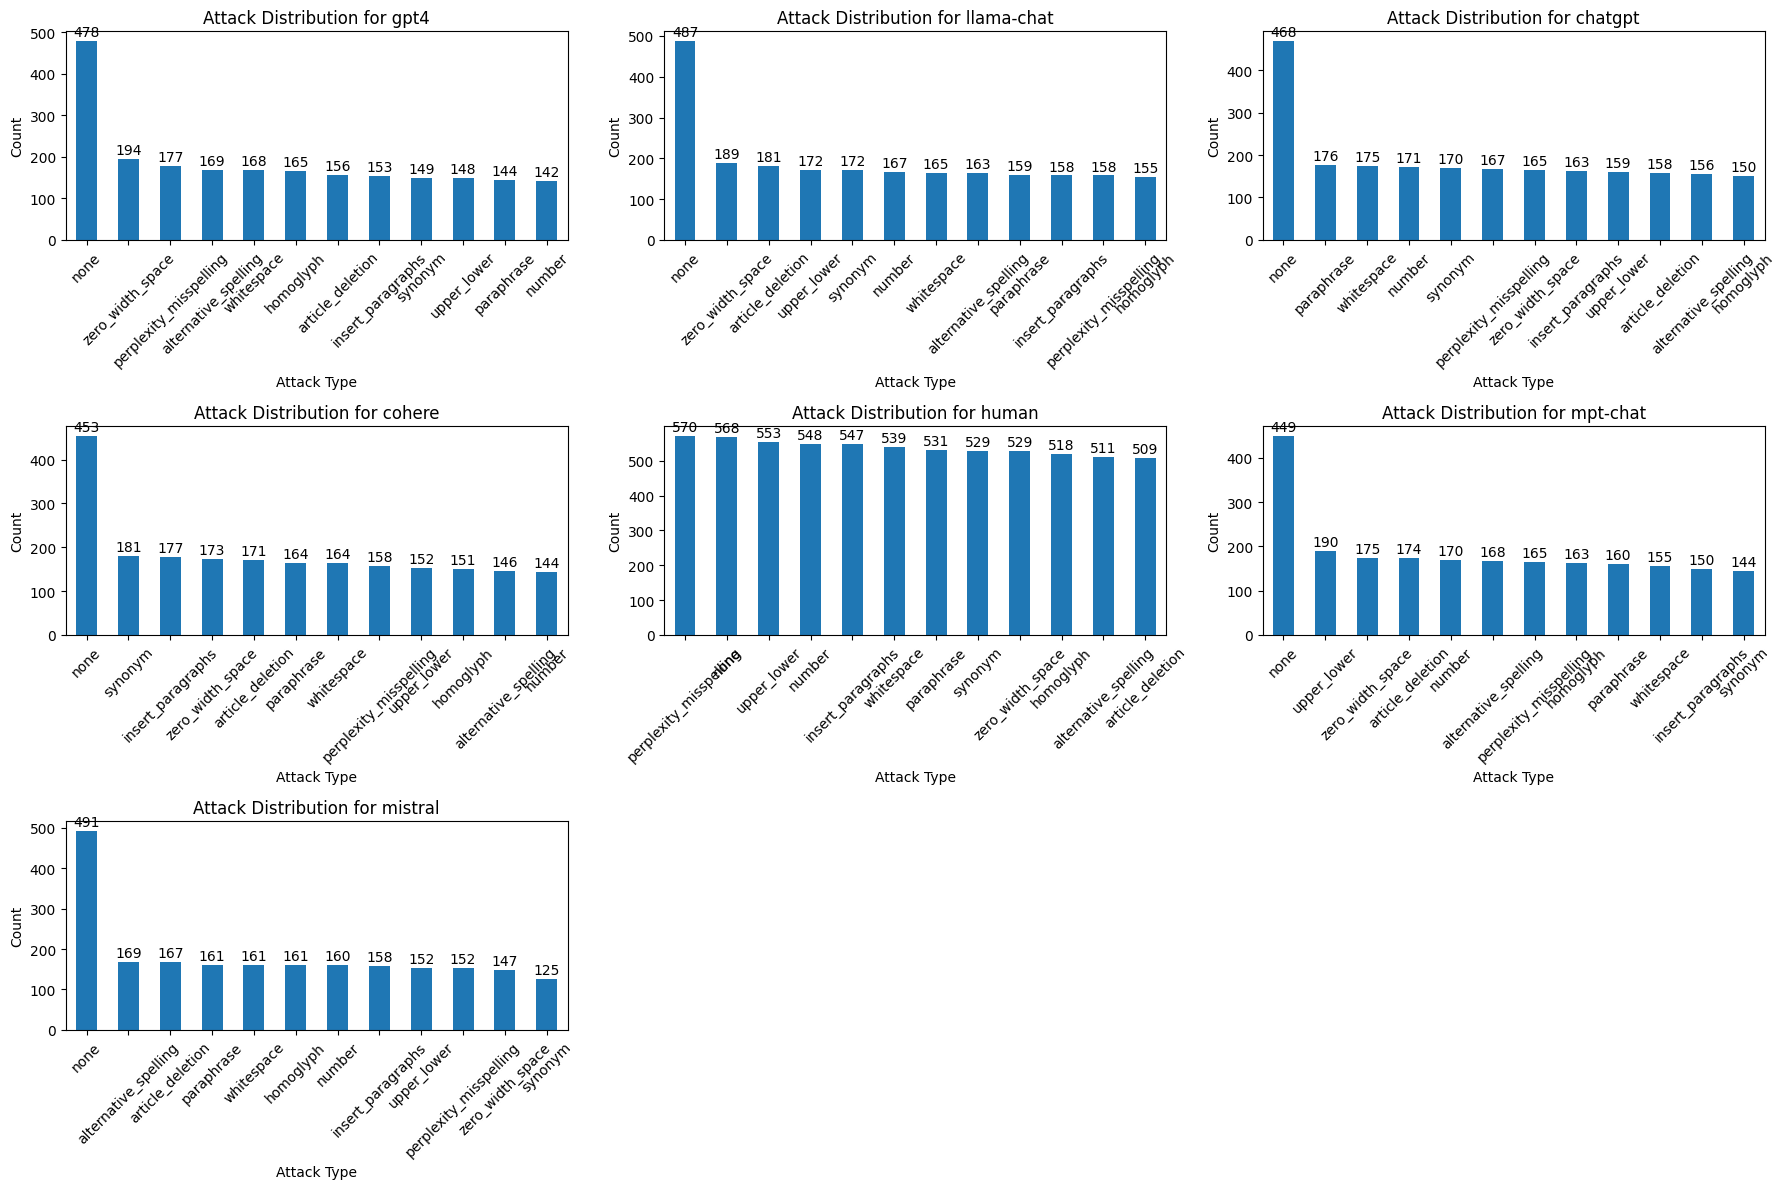


Detailed Attack Distribution by Model (Test Data):

GPT4:
attack
none                      478
zero_width_space          194
perplexity_misspelling    177
alternative_spelling      169
whitespace                168
homoglyph                 165
article_deletion          156
insert_paragraphs         153
synonym                   149
upper_lower               148
paraphrase                144
number                    142
Name: count, dtype: int64
Total samples: 2243

LLAMA-CHAT:
attack
none                      487
zero_width_space          189
article_deletion          181
upper_lower               172
synonym                   172
number                    167
whitespace                165
alternative_spelling      163
paraphrase                159
insert_paragraphs         158
perplexity_misspelling    158
homoglyph                 155
Name: count, dtype: int64
Total samples: 2326

CHATGPT:
attack
none                      468
paraphrase                176
whitespace               

In [13]:
# Plot distribution of model categories in test data
plt.figure(figsize=(12, 6))

# Create subplots for better visualization
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Model distribution
sns.countplot(data=test_data, x='model', ax=axes[0])
axes[0].set_title('Distribution of Models in Test Data')
axes[0].set_xlabel('Model')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=45)

# Plot 2: Label distribution (Human vs AI)
sns.countplot(data=test_data, x='label', ax=axes[1])
axes[1].set_title('Distribution of Labels in Test Data')
axes[1].set_xlabel('Label (0=Human, 1=AI)')
axes[1].set_ylabel('Count')
axes[1].set_xticks([0, 1])
axes[1].set_xticklabels(['Human', 'AI'])

plt.tight_layout()
plt.show()

# Print summary statistics
print("Test Data Distribution Summary:")
print("="*40)
print(f"Total samples: {len(test_data)}")
print(f"\nModel distribution:")
print(test_data['model'].value_counts())
print(f"\nLabel distribution:")
print(test_data['label'].value_counts())

# Plot attack distribution for each model in test data
models = test_data['model'].unique()
n_models = len(models)

# Create subplots - arrange in 2 rows for better visualization
n_cols = 3
n_rows = (n_models + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 12))
axes = axes.flatten()  # Flatten for easier indexing

for i, model in enumerate(models):
    model_data = test_data[test_data['model'] == model]
    
    # Count attack distribution for this model
    attack_counts = model_data['attack'].value_counts()
    
    # Create bar plot
    ax = axes[i]
    attack_counts.plot(kind='bar', ax=ax)
    ax.set_title(f'Attack Distribution for {model}')
    ax.set_xlabel('Attack Type')
    ax.set_ylabel('Count')
    ax.tick_params(axis='x', rotation=45)
    
    # Add value labels on bars
    for j, v in enumerate(attack_counts.values):
        ax.text(j, v + max(attack_counts.values) * 0.01, str(v), ha='center', va='bottom')

# Hide unused subplots
for i in range(n_models, len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

# Print detailed attack distribution per model
print("\nDetailed Attack Distribution by Model (Test Data):")
print("="*60)
for model in models:
    model_data = test_data[test_data['model'] == model]
    print(f"\n{model.upper()}:")
    print(model_data['attack'].value_counts())
    print(f"Total samples: {len(model_data)}")

In [16]:

# Reset indices
train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

# Save test data for future use
# Save test data for future use
test_data.to_csv(test_data_save_path, index=False)
print("Test data saved successfully!")
train_data.to_csv(train_data_save_path, index=False)
print("Train data saved successfully!")


Test data saved successfully!
Train data saved successfully!


In [18]:
test_data.head()

,id,adv_source_id,source_id,model,decoding,repetition_penalty,attack,domain,title,prompt,generation,text,label
0,3a053623-c08d-44e0-9e45-0cde01a045cf,fd90b3ad-5983-4a0b-9c9b-9b95c55005d0,64934a38-a02b-4697-a2c3-04d4ee87e405,gpt4,sampling,no,perplexity_misspelling,wiki,Diagnostic overshadowing,"Write the body of a Wikipedia article titled ""...",Diagnostic overshadowing is a term used in the...,Diagnostic overshadowing Diagnostic overshadow...,1
1,1d41ac6e-3080-4a41-aa79-76bf7b8cf6d1,bc788ab3-1ecb-4995-88c4-083c3559b813,5582f73b-eb15-4504-9e1c-4890c03bc4fc,llama-chat,sampling,no,insert_paragraphs,wiki,Josh Klinghoffer,"Write the body of a Wikipedia article titled ""...","Josh Klinghoffer is an American musician, sing...",Josh Klinghoffer Josh Klinghoffer is an Americ...,1
2,a71904cf-4bf8-4da1-ad11-6b87c16893b8,bef39f66-fa60-45e1-9c0d-f97c4fa366f6,16b97dbd-0972-4701-abac-3418cdaa4504,chatgpt,sampling,no,synonym,news,Troubled Marsh under SEC scrutiny,"Write the body of a BBC news article titled ""T...",US financial regulator the Securities and Exch...,Troubled Marsh under SEC scrutiny US financial...,1
3,a9c723b3-3786-48c9-a11f-d29d712195e4,a9c723b3-3786-48c9-a11f-d29d712195e4,de7526e2-7a63-4705-8f63-929258d07784,cohere,greedy,no,none,poetry,Everybody Dance The Dance Of The Dead,The following is the full text of a poem title...,Everybody dance the dance of the dead\nThough...,Everybody Dance The Dance Of The Dead Everybo...,1
4,2a35ffe0-ef8f-4d7f-864a-378a0ac4cad1,497d022e-5642-4093-948d-d0fe03bdc142,497d022e-5642-4093-948d-d0fe03bdc142,human,NaN,NaN,alternative_spelling,wiki,Free Yourself (song),NaN,"""Free Yourself"" is a song by American singer F...","Free Yourself (song) ""Free Yourself"" is a song...",0


In [ ]:
# Cell 4b - Alternative: Load pre-saved test data only (for future runs)
def load_saved_test_data_only(test_data_path):
    """
    Load pre-saved test data only - no training data needed for model testing
    This saves maximum time on subsequent runs by avoiding all data regeneration
    """
    print("="*60)
    print("LOADING PRE-SAVED TEST DATA ONLY MODE")
    print("="*60)
    
    # Load saved test data
    if os.path.exists(test_data_path):
        print(f"Loading test data from: {test_data_path}")
        test_data = pd.read_csv(test_data_path)
        print(f"Loaded test data shape: {test_data.shape}")
        print(f"Test label distribution:")
        print(test_data['models'].value_counts())
        
        # Count adversarial attacks in test data
        test_adversarial = len(test_data[test_data['attack'].notna() & (test_data['attack'] != 'none')])
        print(f"Adversarial attacks in test set: {test_adversarial}")
        
    else:
        raise FileNotFoundError(f"Saved test data not found at: {test_data_path}")
    
    print("Test data loaded successfully - ready for modification experiments!")
    return test_data

# OPTION 1: Use this if you want to load pre-saved test data only (fastest for subsequent runs)
# Uncomment the line below to use saved test data:

# test_data = load_saved_test_data_only(test_data_save_path)

# OPTION 2: Keep the original approach (current cells above) for first-time data generation

print("Optimized data loading function defined for trained models.")
print("Uncomment the function call above if you want to use pre-saved test data only.")

### Alternative: Load Pre-saved Test Data

**For future runs**, you can skip the time-consuming data loading process by using the saved test data:

```python
# Uncomment these lines to load pre-saved test data instead of regenerating
# print("Loading pre-saved test data...")
# test_data = pd.read_csv(test_data_save_path)
# print(f"Loaded test data shape: {test_data.shape}")
# print(f"Test label distribution: {test_data['models'].value_counts()}")
# 
# # You'll still need to load and sample training data
# # But this saves time on test data generation
```

This is especially useful for:
- **Baseline testing**: Use the same test set across different model modifications
- **Time saving**: Avoid reloading the large RAID dataset each time
- **Reproducibility**: Ensure consistent test data across experiments

## 4. Model and DataLoader Setup

In [19]:
# Cell 5 - Load tokenizer and model
# Load tokenizer and transformer
tokenizer = AutoTokenizer.from_pretrained(model_name)
transformer = AutoModel.from_pretrained(model_name)
config = transformer.config

# Move to device
transformer = transformer.to(device)

print(f"Model: {model_name}")
print(f"Hidden size: {config.hidden_size}")
print(f"Model loaded successfully")

Model: bert-base-cased
Hidden size: 768
Model loaded successfully


In [20]:
# Cell 6 - DataLoader functions
def format_time(elapsed):
    """Format time in seconds to hh:mm:ss"""
    elapsed_rounded = int(round(elapsed))
    return str(datetime.timedelta(seconds=elapsed_rounded))

def create_dataloader(texts, labels, tokenizer, max_length, batch_size, shuffle=False):
    """
    Create DataLoader from texts and labels
    """
    input_ids = []
    attention_masks = []
    
    for text in texts:
        encoded = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    
    # Convert to tensors
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels, dtype=torch.long)
    
    # Create dataset
    dataset = TensorDataset(input_ids, attention_masks, labels)
    
    # Create dataloader
    sampler = RandomSampler(dataset) if shuffle else SequentialSampler(dataset)
    dataloader = DataLoader(dataset, sampler=sampler, batch_size=batch_size)
    
    return dataloader

# Create dataloaders
print("Creating dataloaders...")
train_dataloader = create_dataloader(
    train_data['text'].tolist(),
    train_data['label'].tolist(),
    tokenizer,
    max_seq_length,
    batch_size,
    shuffle=True
)

test_dataloader = create_dataloader(
    test_data['text'].tolist(),
    test_data['label'].tolist(),
    tokenizer,
    max_seq_length,
    batch_size,
    shuffle=False
)

print(f"Train batches: {len(train_dataloader)}")
print(f"Test batches: {len(test_dataloader)}")

Creating dataloaders...
Train batches: 3250
Test batches: 625


## 5. Model Definition

In [21]:
# Cell 7 - Model definition
class BERTClassifier(nn.Module):
    def __init__(self, transformer_model, hidden_size, num_labels, dropout_rate=0.1):
        super(BERTClassifier, self).__init__()
        self.transformer = transformer_model
        self.dropout = nn.Dropout(dropout_rate)
        self.classifier = nn.Linear(hidden_size, num_labels)
        
    def forward(self, input_ids, attention_mask=None):
        # Get transformer outputs
        outputs = self.transformer(input_ids, attention_mask=attention_mask)
        
        # Use [CLS] token representation
        pooled_output = outputs.last_hidden_state[:, 0, :]  # [CLS] token
        
        # Apply dropout and classification
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        
        return logits

# Create model
num_labels = 2  # human vs AI
model = BERTClassifier(
    transformer_model=transformer,
    hidden_size=config.hidden_size,
    num_labels=num_labels,
    dropout_rate=dropout_rate
).to(device)

print(f"Model created with {sum(p.numel() for p in model.parameters())} parameters")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

Model created with 108311810 parameters
Trainable parameters: 108311810


## 6. Training Setup

In [22]:
# Cell 8 - Training setup
# Optimizer and loss function
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

# Learning rate scheduler (optional)
total_steps = len(train_dataloader) * num_train_epochs
warmup_steps = int(0.1 * total_steps)

scheduler = get_constant_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps
)

print(f"Training setup complete")
print(f"Total training steps: {total_steps}")
print(f"Warmup steps: {warmup_steps}")

Training setup complete
Total training steps: 9750
Warmup steps: 975


## 7. Training Loop

In [24]:
# Cell 9 - Training loop
def evaluate_model(model, dataloader, criterion, device):
    """Evaluate model on given dataloader"""
    model.eval()
    total_loss = 0
    total_correct = 0
    total_samples = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch[0].to(device)
            attention_mask = batch[1].to(device)
            labels = batch[2].to(device)
            
            outputs = model(input_ids, attention_mask=attention_mask)
            loss = criterion(outputs, labels)
            
            total_loss += loss.item()
            
            predictions = torch.argmax(outputs, dim=1)
            total_correct += (predictions == labels).sum().item()
            total_samples += labels.size(0)
            
            all_preds.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    avg_loss = total_loss / len(dataloader)
    accuracy = total_correct / total_samples
    
    return avg_loss, accuracy, all_preds, all_labels

# Training loop
print("Starting training...")
training_stats = []
total_t0 = time.time()

for epoch_i in range(num_train_epochs):
    print(f'\n======== Epoch {epoch_i + 1} / {num_train_epochs} ========')
    
    # Training
    t0 = time.time()
    total_train_loss = 0
    model.train()
    
    for step, batch in enumerate(train_dataloader):
        if step % 50 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print(f'  Batch {step:>5,}  of  {len(train_dataloader):>5,}.    Elapsed: {elapsed}.')
        
        # Move batch to device
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)
        
        # Clear gradients
        model.zero_grad()
        
        # Forward pass
        outputs = model(input_ids, attention_mask=attention_mask)
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        
        # Clip gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        # Update parameters
        optimizer.step()
        scheduler.step()
        
        total_train_loss += loss.item()
    
    # Calculate average training loss
    avg_train_loss = total_train_loss / len(train_dataloader)
    training_time = format_time(time.time() - t0)
    
    print(f"\n  Average training loss: {avg_train_loss:.3f}")
    print(f"  Training epoch took: {training_time}")
    
    # Evaluation
    print("\n  Running Validation...")
    t0 = time.time()
    
    val_loss, val_accuracy, val_preds, val_labels = evaluate_model(
        model, test_dataloader, criterion, device
    )
    
    validation_time = format_time(time.time() - t0)
    
    print(f"  Validation Loss: {val_loss:.3f}")
    print(f"  Validation Accuracy: {val_accuracy:.3f}")
    print(f"  Validation took: {validation_time}")
    
    # Record statistics
    training_stats.append({
        'epoch': epoch_i + 1,
        'Training Loss': avg_train_loss,
        'Valid. Loss': val_loss,
        'Valid. Accur.': val_accuracy,
        'Training Time': training_time,
        'Validation Time': validation_time
    })

print(f"\nTraining complete!")
print(f"Total training took {format_time(time.time() - total_t0)}")

Starting training...

======== Epoch 1 / 3 ========
  Batch    50  of  3,250.    Elapsed: 0:00:13.
  Batch   100  of  3,250.    Elapsed: 0:00:22.
  Batch   150  of  3,250.    Elapsed: 0:00:32.
  Batch   200  of  3,250.    Elapsed: 0:00:41.
  Batch   250  of  3,250.    Elapsed: 0:00:50.
  Batch   300  of  3,250.    Elapsed: 0:00:59.
  Batch   350  of  3,250.    Elapsed: 0:01:08.
  Batch   400  of  3,250.    Elapsed: 0:01:18.
  Batch   450  of  3,250.    Elapsed: 0:01:27.
  Batch   500  of  3,250.    Elapsed: 0:01:36.
  Batch   550  of  3,250.    Elapsed: 0:01:45.
  Batch   600  of  3,250.    Elapsed: 0:01:54.
  Batch   650  of  3,250.    Elapsed: 0:02:04.
  Batch   700  of  3,250.    Elapsed: 0:02:13.
  Batch   750  of  3,250.    Elapsed: 0:02:22.
  Batch   800  of  3,250.    Elapsed: 0:02:31.
  Batch   850  of  3,250.    Elapsed: 0:02:40.
  Batch   900  of  3,250.    Elapsed: 0:02:49.
  Batch   950  of  3,250.    Elapsed: 0:02:58.
  Batch 1,000  of  3,250.    Elapsed: 0:03:08.
  Batch 

## 8. Model Saving

In [25]:
# Cell 10 - Save the trained model
# Save the complete model state
torch.save({
    'epoch': num_train_epochs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'training_stats': training_stats,
    'model_config': {
        'model_name': model_name,
        'hidden_size': config.hidden_size,
        'num_labels': num_labels,
        'dropout_rate': dropout_rate,
        'max_seq_length': max_seq_length
    }
}, model_save_path)

print(f"Model saved to: {model_save_path}")

# Also save tokenizer
tokenizer_save_path = os.path.join(model_save_dir, "tokenizer")
tokenizer.save_pretrained(tokenizer_save_path)
print(f"Tokenizer saved to: {tokenizer_save_path}")

# Print training statistics
print("\nTraining Statistics:")
stats_df = pd.DataFrame(training_stats)
print(stats_df)

# Final evaluation with detailed metrics
print("\n" + "="*50)
print("FINAL EVALUATION RESULTS")
print("="*50)

final_loss, final_accuracy, final_preds, final_labels = evaluate_model(
    model, test_dataloader, criterion, device
)

print(f"Final Test Accuracy: {final_accuracy:.4f}")
print(f"Final Test Loss: {final_loss:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(final_labels, final_preds, target_names=['Human', 'AI']))

# Confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(final_labels, final_preds))

Model saved to: ./saved_models/bert_finetuned_model.pth
Tokenizer saved to: ./saved_models/tokenizer

Training Statistics:
   epoch  Training Loss  Valid. Loss  Valid. Accur. Training Time  \
0      1       0.240898     0.185388        0.93535       0:10:01   
1      2       0.089197     0.394524        0.89725       0:09:56   
2      3       0.052604     0.240962        0.94775       0:09:56   

  Validation Time  
0         0:00:36  
1         0:00:36  
2         0:00:36  

FINAL EVALUATION RESULTS
Final Test Accuracy: 0.9477
Final Test Loss: 0.2410

Classification Report:
              precision    recall  f1-score   support

       Human       0.98      0.85      0.91      6452
          AI       0.93      0.99      0.96     13548

    accuracy                           0.95     20000
   macro avg       0.96      0.92      0.94     20000
weighted avg       0.95      0.95      0.95     20000


Confusion Matrix:
[[ 5513   939]
 [  106 13442]]


## 9. Model Loading and Test Data Modification Pipeline

In [ ]:
# Cell 11 - Model loading function
def load_saved_model(model_path, tokenizer_path, device):
    """
    Load the saved model and tokenizer
    """
    # Load checkpoint
    checkpoint = torch.load(model_path, map_location=device)
    
    # Get model config
    model_config = checkpoint['model_config']
    
    # Recreate tokenizer
    tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)
    
    # Recreate transformer
    transformer = AutoModel.from_pretrained(model_config['model_name']).to(device)
    
    # Recreate model
    model = BERTClassifier(
        transformer_model=transformer,
        hidden_size=model_config['hidden_size'],
        num_labels=model_config['num_labels'],
        dropout_rate=model_config['dropout_rate']
    ).to(device)
    
    # Load state dict
    model.load_state_dict(checkpoint['model_state_dict'])
    
    return model, tokenizer, checkpoint

def test_model_accuracy(model, test_dataloader, device, test_name="Test"):
    """
    Test model accuracy on given dataloader
    """
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in test_dataloader:
            input_ids = batch[0].to(device)
            attention_mask = batch[1].to(device)
            labels = batch[2].to(device)
            
            outputs = model(input_ids, attention_mask=attention_mask)
            predictions = torch.argmax(outputs, dim=1)
            
            total += labels.size(0)
            correct += (predictions == labels).sum().item()
            
            all_preds.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = correct / total
    
    print(f"\n{test_name} Results:")
    print(f"Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"Correct: {correct}/{total}")
    
    return accuracy, all_preds, all_labels

print("Model loading and testing functions defined.")

## 10. Baseline Testing on Original Test Data

In [ ]:
# Cell 12 - Load saved model and test baseline
print("Loading saved model for test data modification experiments...")

# Load the saved model
loaded_model, loaded_tokenizer, checkpoint = load_saved_model(
    model_save_path, 
    tokenizer_save_path, 
    device
)

print("Model loaded successfully!")
print(f"Training epochs completed: {checkpoint['epoch']}")

# Test baseline accuracy on original test data
baseline_accuracy, baseline_preds, baseline_labels = test_model_accuracy(
    loaded_model, test_dataloader, device, "Baseline (Original Test Data)"
)

# Store baseline results for comparison
results_comparison = {
    "Baseline_Original": {
        "accuracy": baseline_accuracy,
        "predictions": baseline_preds,
        "labels": baseline_labels,
        "description": "Original test data without modifications"
    }
}

print(f"\nBaseline accuracy stored: {baseline_accuracy:.4f}")

## 11. Test Data Modification and Testing Framework

In [ ]:
# Cell 13 - NLP Data Modification Functions
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import random

# Download required NLTK data (run once)
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')

def create_modified_test_dataloader(original_test_data, modification_func, modification_name, 
                                  tokenizer, max_length, batch_size, device):
    """
    Generate modified test dataloader in one go
    """
    print(f"\nApplying {modification_name} to test data...")
    
    # Apply modification to test texts
    modified_texts = []
    for text in original_test_data['text'].tolist():
        modified_text = modification_func(text)
        modified_texts.append(modified_text)
    
    # Create new dataloader with modified texts but same labels
    modified_dataloader = create_dataloader(
        modified_texts,
        original_test_data['label'].tolist(),
        tokenizer,
        max_length,
        batch_size,
        shuffle=False
    )
    
    print(f"Created modified dataloader with {len(modified_texts)} samples")
    return modified_dataloader, modified_texts

# NLP Modification Functions
def add_random_noise_words(text, noise_ratio=0.1):
    """Add random words to text"""
    words = text.split()
    num_noise_words = int(len(words) * noise_ratio)
    noise_words = ['random', 'noise', 'word', 'addition', 'test', 'sample']
    
    for _ in range(num_noise_words):
        position = random.randint(0, len(words))
        words.insert(position, random.choice(noise_words))
    
    return ' '.join(words)

def remove_stopwords(text):
    """Remove stopwords from text"""
    try:
        stop_words = set(stopwords.words('english'))
        words = word_tokenize(text.lower())
        filtered_words = [word for word in words if word not in stop_words and word.isalpha()]
        return ' '.join(filtered_words)
    except:
        # Fallback if NLTK data not available
        common_stopwords = ['the', 'a', 'an', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for', 'of', 'with', 'by']
        words = text.lower().split()
        filtered_words = [word for word in words if word not in common_stopwords]
        return ' '.join(filtered_words)

def add_typos(text, typo_ratio=0.05):
    """Add random typos to text"""
    words = text.split()
    num_typos = int(len(words) * typo_ratio)
    
    for _ in range(num_typos):
        if words:  # Check if words list is not empty
            word_idx = random.randint(0, len(words) - 1)
            word = words[word_idx]
            if len(word) > 2:
                # Random character substitution
                char_idx = random.randint(1, len(word) - 2)
                new_char = random.choice('abcdefghijklmnopqrstuvwxyz')
                words[word_idx] = word[:char_idx] + new_char + word[char_idx+1:]
    
    return ' '.join(words)

def truncate_text(text, truncate_ratio=0.7):
    """Truncate text to a certain percentage"""
    words = text.split()
    truncate_length = int(len(words) * truncate_ratio)
    return ' '.join(words[:truncate_length])

def add_punctuation_noise(text):
    """Add random punctuation"""
    noise_punct = ['.', ',', '!', '?', ';', ':']
    words = text.split()
    
    for i in range(0, len(words), 5):  # Add punctuation every 5 words
        if i < len(words):
            words[i] += random.choice(noise_punct)
    
    return ' '.join(words)

def uppercase_random_words(text, ratio=0.1):
    """Convert random words to uppercase"""
    words = text.split()
    num_uppercase = int(len(words) * ratio)
    
    for _ in range(num_uppercase):
        if words:
            word_idx = random.randint(0, len(words) - 1)
            words[word_idx] = words[word_idx].upper()
    
    return ' '.join(words)

print("NLP modification functions defined!")

In [ ]:
# Cell 14 - Test Data Modification Examples

# Example 1: Add noise words
print("="*50)
print("Testing with Random Noise Words")
print("="*50)

noise_dataloader, noise_texts = create_modified_test_dataloader(
    test_data, add_random_noise_words, "Random Noise Words", 
    loaded_tokenizer, max_seq_length, batch_size, device
)

noise_accuracy, noise_preds, noise_labels = test_model_accuracy(
    loaded_model, noise_dataloader, device, "Random Noise Words"
)

results_comparison["Noise_Words"] = {
    "accuracy": noise_accuracy,
    "predictions": noise_preds,
    "labels": noise_labels,
    "description": "Added random noise words to 10% of text"
}

print(f"Accuracy change from baseline: {noise_accuracy - baseline_accuracy:+.4f}")

# Example 2: Remove stopwords
print("\n" + "="*50)
print("Testing with Stopwords Removed")
print("="*50)

stopwords_dataloader, stopwords_texts = create_modified_test_dataloader(
    test_data, remove_stopwords, "Stopwords Removed", 
    loaded_tokenizer, max_seq_length, batch_size, device
)

stopwords_accuracy, stopwords_preds, stopwords_labels = test_model_accuracy(
    loaded_model, stopwords_dataloader, device, "Stopwords Removed"
)

results_comparison["Stopwords_Removed"] = {
    "accuracy": stopwords_accuracy,
    "predictions": stopwords_preds,
    "labels": stopwords_labels,
    "description": "Removed common English stopwords"
}

print(f"Accuracy change from baseline: {stopwords_accuracy - baseline_accuracy:+.4f}")

# Example 3: Add typos
print("\n" + "="*50)
print("Testing with Added Typos")
print("="*50)

typos_dataloader, typos_texts = create_modified_test_dataloader(
    test_data, add_typos, "Added Typos", 
    loaded_tokenizer, max_seq_length, batch_size, device
)

typos_accuracy, typos_preds, typos_labels = test_model_accuracy(
    loaded_model, typos_dataloader, device, "Added Typos"
)

results_comparison["Added_Typos"] = {
    "accuracy": typos_accuracy,
    "predictions": typos_preds,
    "labels": typos_labels,
    "description": "Added random typos to 5% of words"
}

print(f"Accuracy change from baseline: {typos_accuracy - baseline_accuracy:+.4f}")

In [ ]:
# Cell 15 - Custom Test Data Modification Template

def your_custom_text_modification(text):
    """
    Template for your custom text modifications
    Add your NLP modification logic here
    """
    # Example custom modifications:
    
    # 1. Text truncation
    # words = text.split()
    # return ' '.join(words[:len(words)//2])
    
    # 2. Word order shuffling
    # words = text.split()
    # random.shuffle(words)
    # return ' '.join(words)
    
    # 3. Sentence case modification
    # return text.lower()
    
    # 4. Remove numbers
    # return re.sub(r'\d+', '', text)
    
    # 5. Replace specific words
    # return text.replace('the', 'a').replace('is', 'was')
    
    # Add your custom modification here
    return text  # Return original text for now

# Test your custom modification (uncomment and modify below)
# print("\n" + "="*50)
# print("Testing with Custom Modification")
# print("="*50)

# custom_dataloader, custom_texts = create_modified_test_dataloader(
#     test_data, your_custom_text_modification, "Custom Modification", 
#     loaded_tokenizer, max_seq_length, batch_size, device
# )

# custom_accuracy, custom_preds, custom_labels = test_model_accuracy(
#     loaded_model, custom_dataloader, device, "Custom Modification"
# )

# results_comparison["Custom_Modification"] = {
#     "accuracy": custom_accuracy,
#     "predictions": custom_preds,
#     "labels": custom_labels,
#     "description": "Your custom text modification"
# }

# print(f"Accuracy change from baseline: {custom_accuracy - baseline_accuracy:+.4f}")

print("Custom text modification template ready for your use!")
print("Modify the 'your_custom_text_modification' function above and uncomment the test code.")

## 12. Test Data Modification Results Comparison

In [ ]:
# Cell 16 - Compare all test data modification results
print("\n" + "="*70)
print("COMPREHENSIVE TEST DATA MODIFICATION RESULTS COMPARISON")
print("="*70)

# Create comparison dataframe
comparison_data = []
for modification_name, results in results_comparison.items():
    comparison_data.append({
        'Test_Data_Modification': modification_name,
        'Accuracy': f"{results['accuracy']:.4f}",
        'Accuracy_Numeric': results['accuracy'],
        'Change_from_Baseline': f"{results['accuracy'] - baseline_accuracy:+.4f}",
        'Description': results['description']
    })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('Accuracy_Numeric', ascending=False)

print("\nAccuracy Comparison Across Different Test Data Modifications:")
print(comparison_df[['Test_Data_Modification', 'Accuracy', 'Change_from_Baseline', 'Description']].to_string(index=False))

# Find best and worst performing modifications
best_mod = comparison_df.iloc[0]
worst_mod = comparison_df.iloc[-1]

print(f"\nBest performing test: {best_mod['Test_Data_Modification']} ({best_mod['Accuracy']})")
print(f"Worst performing test: {worst_mod['Test_Data_Modification']} ({worst_mod['Accuracy']})")

# Calculate performance impact
max_accuracy = comparison_df['Accuracy_Numeric'].max()
min_accuracy = comparison_df['Accuracy_Numeric'].min()
accuracy_range = max_accuracy - min_accuracy

print(f"\nAccuracy range across modifications: {accuracy_range:.4f}")
print(f"Maximum accuracy: {max_accuracy:.4f}")
print(f"Minimum accuracy: {min_accuracy:.4f}")

# Analyze modification impacts
print(f"\nModification Impact Analysis:")
for _, row in comparison_df.iterrows():
    if row['Test_Data_Modification'] != 'Baseline_Original':
        impact = "improved" if row['Accuracy_Numeric'] > baseline_accuracy else "degraded"
        print(f"- {row['Test_Data_Modification']}: {impact} accuracy by {abs(row['Accuracy_Numeric'] - baseline_accuracy):.4f}")

# Save comparison results
results_save_path = os.path.join(model_save_dir, "test_data_modification_comparison.csv")
comparison_df.to_csv(results_save_path, index=False)
print(f"\nResults saved to: {results_save_path}")

# Show example modifications
print(f"\n" + "="*50)
print("EXAMPLE TEXT MODIFICATIONS")
print("="*50)
original_text = test_data['text'].iloc[0][:200] + "..."  # First 200 chars
print(f"Original text: {original_text}")
print(f"\nNoise words added: {add_random_noise_words(original_text)}")
print(f"\nStopwords removed: {remove_stopwords(original_text)}")
print(f"\nWith typos: {add_typos(original_text)}")

## 13. Instructions for Test Data Modification Experiments

This pipeline is now optimized for test data modification experiments! Here's how to use it:

### Workflow:
1. **Train model once** (Cells 1-10) - Model stays constant
2. **Load trained model** (Cell 11-12) - Get baseline accuracy
3. **Apply NLP modifications** (Cells 13-15) - Modify test data only
4. **Compare results** (Cell 16) - See how modifications affect accuracy

### To add new test data modifications:
1. Create a new function that takes text and returns modified text
2. Use `create_modified_test_dataloader()` to generate the new test set
3. Test with `test_model_accuracy()` 
4. Add results to `results_comparison`

### Available NLP modifications:
- **Random noise words**: Adds random words to text
- **Stopword removal**: Removes common English stopwords
- **Typo injection**: Adds random character substitutions
- **Text truncation**: Cuts text to specified length
- **Punctuation noise**: Adds random punctuation
- **Case modification**: Changes word cases randomly

### Example custom modifications you could try:
- Synonym replacement
- Sentence reordering  
- Grammar modifications
- Domain-specific word replacement
- Style transfer
- Paraphrasing
- Translation back-translation

In [ ]:
# Cell 17 - Additional utility functions for test data modifications

def batch_modify_texts(texts, modification_func, batch_size=1000):
    """
    Apply modification to texts in batches for memory efficiency
    """
    modified_texts = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        batch_modified = [modification_func(text) for text in batch]
        modified_texts.extend(batch_modified)
        if i % (batch_size * 10) == 0:
            print(f"Processed {i}/{len(texts)} texts...")
    return modified_texts

def compare_text_lengths(original_texts, modified_texts, modification_name):
    """
    Compare text lengths before and after modification
    """
    orig_lengths = [len(text.split()) for text in original_texts[:100]]  # Sample 100
    mod_lengths = [len(text.split()) for text in modified_texts[:100]]
    
    print(f"\n{modification_name} - Length Analysis:")
    print(f"Original avg length: {np.mean(orig_lengths):.1f} words")
    print(f"Modified avg length: {np.mean(mod_lengths):.1f} words")
    print(f"Length change: {np.mean(mod_lengths) - np.mean(orig_lengths):+.1f} words")

def save_modified_test_data(modified_texts, original_labels, modification_name, save_dir):
    """
    Save modified test data to CSV for future use
    """
    modified_df = pd.DataFrame({
        'text': modified_texts,
        'label': original_labels,
        'modification': modification_name
    })
    
    save_path = os.path.join(save_dir, f"modified_test_{modification_name.lower().replace(' ', '_')}.csv")
    modified_df.to_csv(save_path, index=False)
    print(f"Modified test data saved to: {save_path}")
    return save_path

def quick_modification_test(test_data, modification_func, modification_name, model, tokenizer, device):
    """
    Quick function to test a modification and get results in one go
    """
    print(f"\n{'='*60}")
    print(f"TESTING: {modification_name}")
    print(f"{'='*60}")
    
    # Create modified dataloader
    modified_dataloader, modified_texts = create_modified_test_dataloader(
        test_data, modification_func, modification_name, 
        tokenizer, max_seq_length, batch_size, device
    )
    
    # Test accuracy
    accuracy, preds, labels = test_model_accuracy(
        model, modified_dataloader, device, modification_name
    )
    
    # Compare lengths
    compare_text_lengths(test_data['text'].tolist(), modified_texts, modification_name)
    
    return accuracy, preds, labels, modified_texts

print("\n" + "="*60)
print("TEST DATA MODIFICATION PIPELINE SETUP COMPLETE!")
print("="*60)
print("\nYour pipeline is ready for NLP-based test data modification experiments!")
print("\nKey features:")
print("- Model trained once and stays constant")
print("- Easy test data modification with NLP techniques")  
print("- Automatic accuracy comparison")
print("- Built-in text analysis utilities")
print("- Extensible framework for custom modifications")
print("\nNext steps:")
print("1. Run cells 1-12 to train model and get baseline")
print("2. Modify test data using provided functions (cells 13-15)")
print("3. Compare results and analyze impact (cell 16)")
print("4. Create your own modifications using the templates!")